## Bayesian analysis of the positions taken by F1 drivers in each race of the 2022-2024 hybrid era.
### Andrzej Janik, Łukasz Gakan
### Data Analytics 2024
### Automatic Control and Robotics - Computer Science in Control and Management

### 1. Project formulation
The goal of the project is to conduct a Bayesian analysis of the places held by Formula One drivers in individual races in the hybrid era, spanning 2022-2024. The hybrid era, characterized by advanced hybrid powertrain technologies, has introduced new challenges and opportunities that significantly affect race results and team strategies. The analysis aims to identify patterns and factors affecting driver performance in this modern era, using Bayesian analysis tools. The project will collect and analyze data on the results of F1 races from 2022-2024, including drivers' starting and finishing positions, weather conditions, times and finishing positions from other sessions i.e qualifications, sprint qualifications, free practices. 

##### Point of creating model and potential use cases
Bayesian analysis will make it possible to model the relationship between these variables, identifying the key factors affecting drivers' final positions and to predict future results based on current data. This will enable better preparation of teams for future races, as well as a better understanding of the dynamics of competition in the hybrid era of Formula One. The analysis results can be utilized for educating new team members and drivers, helping them better understand the factors affecting their performance and to develop more effective strategies for upcoming races. Outcome can be highly useful for people involved in betting, as it can predict the positions of drivers with greater accuracy, thereby increasing the chances of winning bets. The last use case is that FIA (The Fédération Internationale de l'Automobile) can leverage the model to evaluate the impact of new technical regulations. This can help enhance the overall spectacle for fans by ensuring closer and more exciting races.

##### Description of data
The data for all sessions from the hybrid era (seasons 2022, 2023, 2024) were scraped from the official Formula 1 website (https://www.formula1.com), and the weather data were obtained using the FastF1 API. After that, the data from each race weekend were appropriately merged and sorted.
Below is the representation of all columns in the prepared dataset:

1. **Year**: The year in which the race took place.
2. **Race**: The name or location of the race.
3. **No**: The car number of the driver.
4. **Driver**: The name of the driver.
5. **Car**: The team or manufacturer of the car.
6. **Pos (race)**: The final position of the driver in the race.
7. **Laps (race)**: The number of laps completed by the driver in the race.
8. **Time/Retired**: The race completion time of the driver or the reason for retirement if the driver did not finish the race.
9. **Points**: The points awarded to the driver for the race.
10. **Pos (qualifying)**: The position of the driver in the qualifying session.
11. **Q1**: The time of the driver in the first qualifying session.
12. **Q2**: The time of the driver in the second qualifying session.
13. **Q3**: The time of the driver in the third qualifying session.
14. **Pos (FP1)**: The position of the driver in the first free practice session.
15. **Time (FP1)**: The time of the driver in the first free practice session.
16. **Gap (FP1)**: The time gap between the driver and the fastest driver in the first free practice session.
17. **Laps (FP1)**: The number of laps completed by the driver in the first free practice session.
18. **Pos (FP2)**: The position of the driver in the second free practice session.
19. **Time (FP2)**: The time of the driver in the second free practice session.
20. **Gap (FP2)**: The time gap between the driver and the fastest driver in the second free practice session.
21. **Laps (FP2)**: The number of laps completed by the driver in the second free practice session.
22. **Pos (FP3)**: The position of the driver in the third free practice session.
23. **Time (FP3)**: The time of the driver in the third free practice session.
24. **Gap (FP3)**: The time gap between the driver and the fastest driver in the third free practice session.
25. **Laps (FP3)**: The number of laps completed by the driver in the third free practice session.
26. **Pos (Sprint)**: The position of the driver in the sprint race (if sprint weekend).
27. **Laps (Sprint)**: The number of laps completed by the driver in the sprint race (if sprint weekend).
28. **Time/Retired (Sprint)**: The sprint race completion time of the driver or the reason for retirement if the driver did not finish the sprint race (if sprint weekend).
29. **Points (Sprint)**: The points awarded to the driver for the sprint race (if sprint weekend).
30. **Pos (Sprint Quali)**: The position of the driver in the sprint qualifying session (if sprint weekend).
31. **SQ1**: The time of the driver in the first sprint qualifying session (if sprint weekend).
32. **SQ2**: The time of the driver in the second sprint qualifying session (if sprint weekend).
33. **SQ3**: The time of the driver in the third sprint qualifying session (if asprint weekend).
34. **Laps (Sprint Quali)**: The number of laps completed by the driver in the sprint qualifying session (if sprint weekend).
35. **AvgAirTemp**: The average air temperature during the race.
36. **AvgHumidity**: The average humidity during the race.
37. **AvgPressure**: The average atmospheric pressure during the race.
38. **TotalRainfall**: The total rainfall during the race.
39. **AvgTrackTemp**: The average track temperature during the race.
40. **AvgWindDirection**: The average wind direction during the race.
41. **AvgWindSpeed**: The average wind speed during the race.

##### DAG
To visualize the relationships between the variables, we use a Directed Acyclic Graph (DAG):

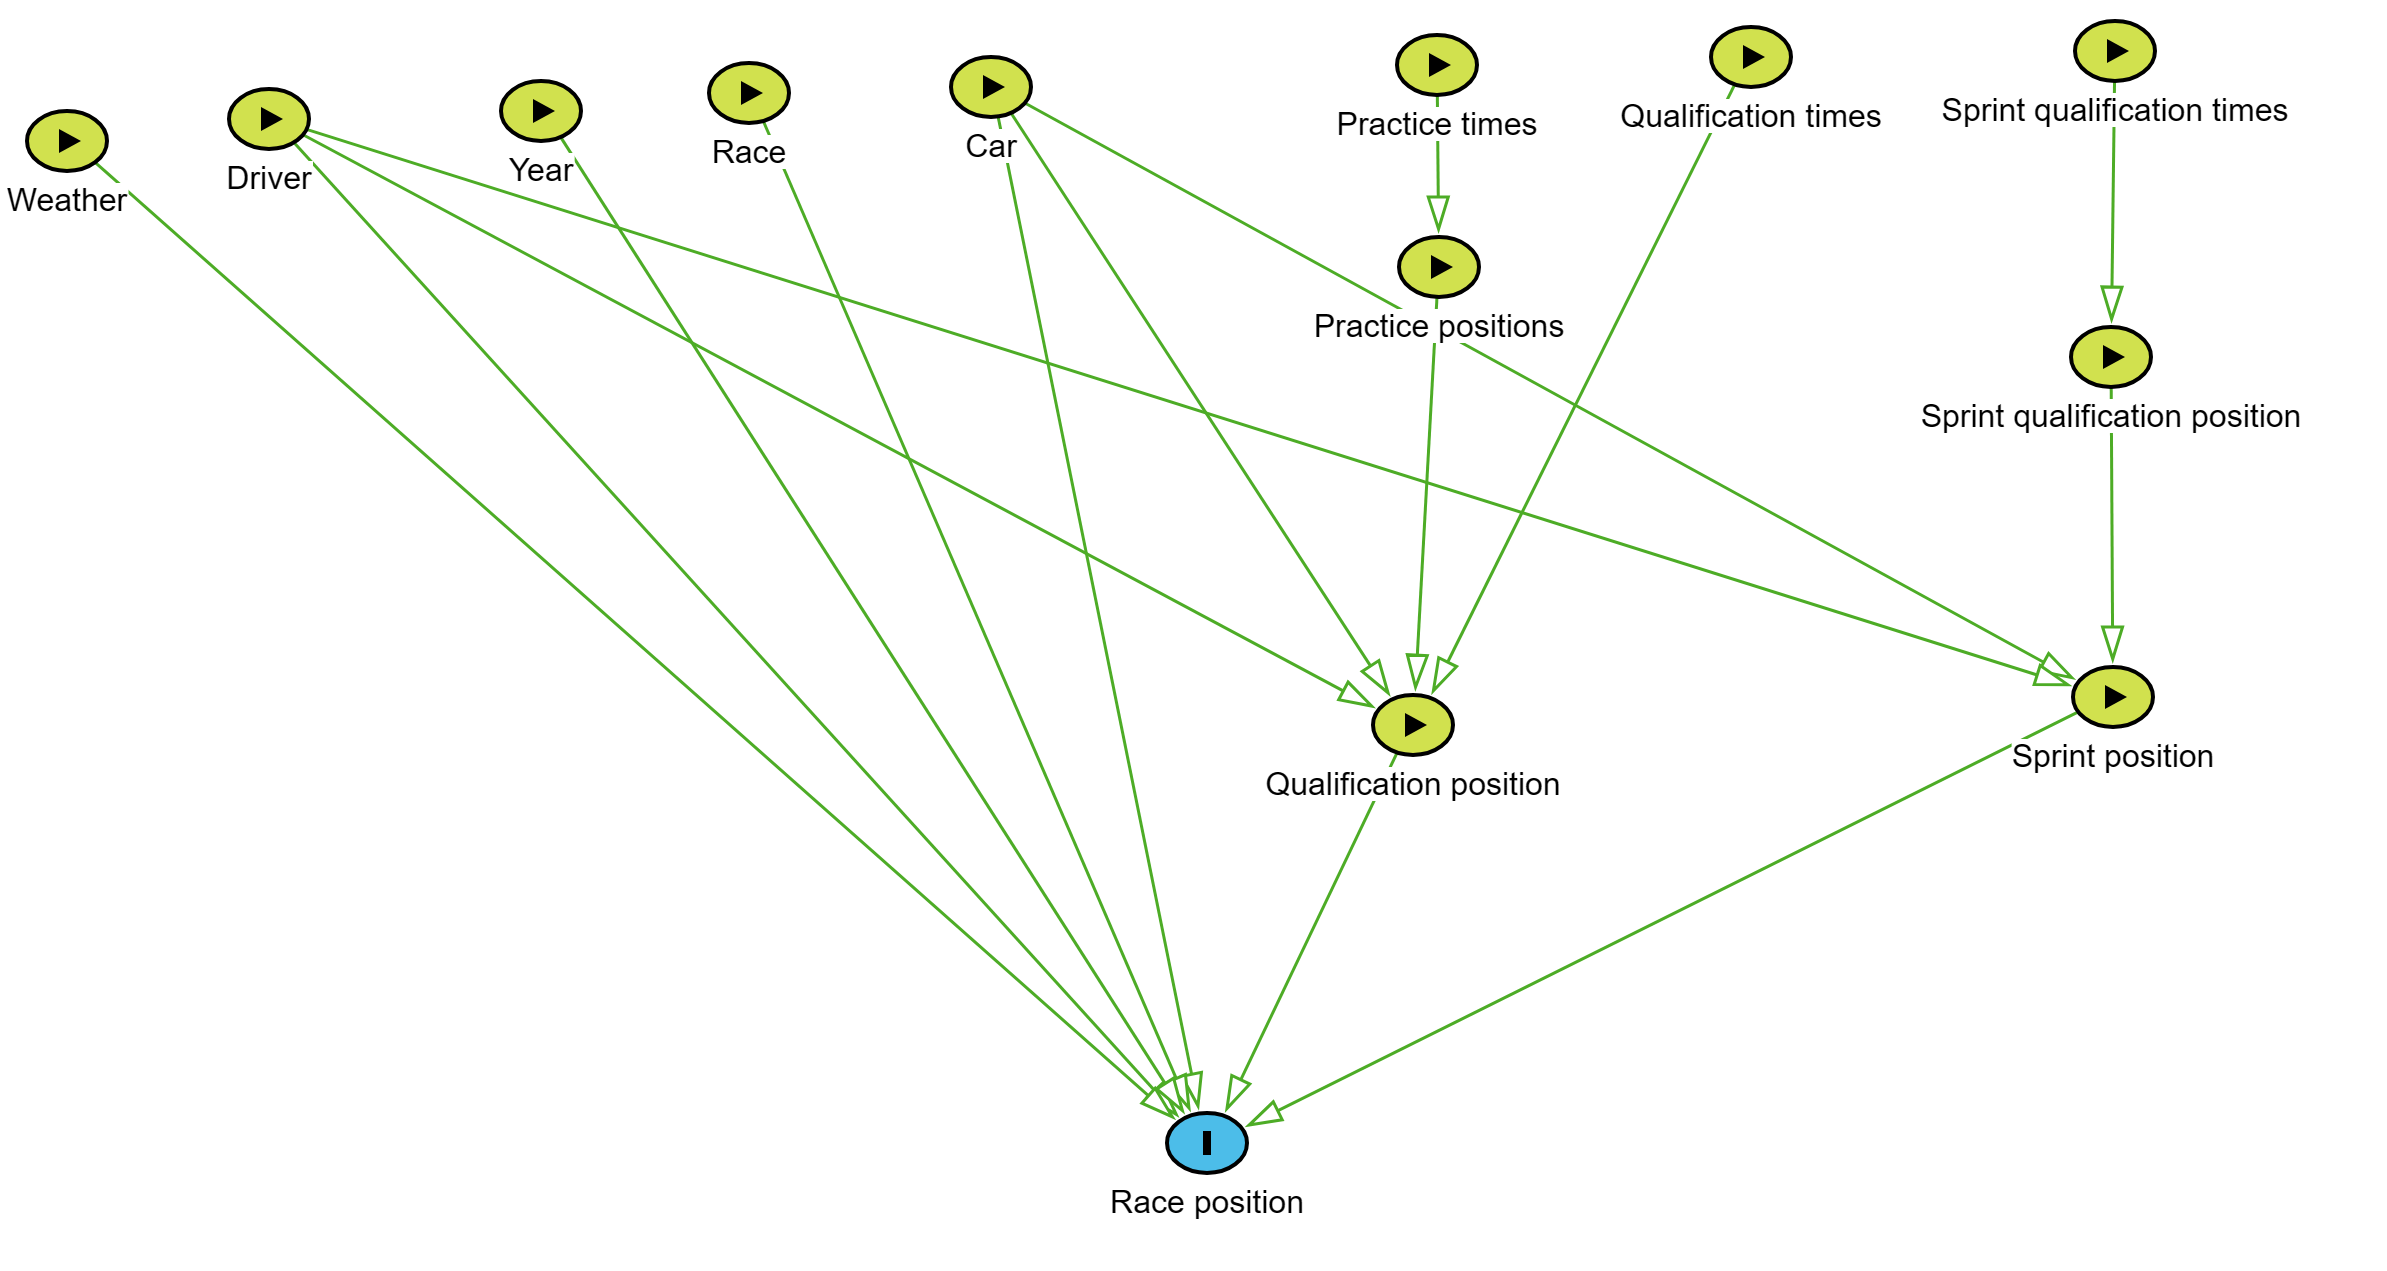

In [1]:
from PIL import Image
from IPython.display import display

DAG = Image.open('DAG.png')
display(DAG)

##### Confoundings
1. **Pipes**:
<br>Weather -> Race position,
<br>Driver -> Race position,
<br>Driver -> Qualification position -> Race position,
<br>Driver -> Sprint position -> Race position,
<br>Year -> Race position,
<br>Race -> Race position,
<br>Car -> Race position,
<br>Car -> Qualification position -> Race position,
<br>Car -> Sprint position -> Race position,
<br>Practice times -> Practice positions -> Qualification position -> Race position,
<br>Qualification times -> Qualification position,
<br>Sprint qualification times -> Sprint qualification position -> Race position.

2. **Forks**:
<br>Driver cause changes in Race position, Qualification position and Sprint position,
<br>Car cause changes in Race position, Qualification position and Sprint position.

3. **Colliders**:
<br>Qualification position and Sprint position cause changes in Race position which is our outcome of analysis.

### 2. Data Preprocessing

In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
original_data = pd.read_csv('final_f1_data.csv')
original_data.head()

,Year,Race,No,Driver,Car,Pos (race),Laps (race),Time/Retired,Points,Pos (qualifying),...,SQ2,SQ3,Laps (Sprint Quali),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed
0,2022,Bahrain,16,Charles Leclerc LEC,Ferrari,1,57.0,1:37:33:584,26.0,1,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
1,2022,Bahrain,10,Pierre Gasly GAS,AlphaTauri RBPT,NC,44.0,DNF,0.0,10,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
2,2022,Bahrain,1,Max Verstappen VER,Red Bull Racing RBPT,19,54.0,DNF,0.0,2,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
3,2022,Bahrain,11,Sergio Perez PER,Red Bull Racing RBPT,18,56.0,DNF,0.0,4,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
4,2022,Bahrain,27,Nico Hulkenberg HUL,Aston Martin Aramco Mercedes,17,57.0,+63.829s,0.0,17,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3


In [4]:
original_data.describe()

,Year,No,Laps (race),Points,Pos (FP1),Laps (FP1),Pos (FP2),Laps (FP2),Pos (FP3),Laps (FP3),Laps (Sprint),Points (Sprint),Laps (Sprint Quali),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed
count,1048.000000,1048.000000,998.000000,998.000000,996.000000,996.000000,805.000000,805.000000,777.000000,777.000000,219.000000,219.000000,160.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,2022.669847,27.684160,54.092184,5.105210,10.464859,21.462851,10.350311,25.371429,10.463320,18.615187,19.150685,1.808219,12.050000,24.150658,52.957653,987.579284,10.746183,35.564170,182.211422,1.888263
std,0.674099,23.115599,16.418655,7.259757,5.753720,7.594340,5.710601,7.053627,5.750751,4.703577,5.292381,2.647437,4.821075,4.787239,17.095960,52.604867,38.036584,8.090855,61.259309,1.018147
min,2022.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,12.900000,7.110000,779.520000,0.000000,17.420000,87.800000,0.300000
25%,2022.000000,11.000000,50.000000,0.000000,5.000000,19.000000,5.000000,22.000000,5.000000,16.000000,19.000000,0.000000,8.000000,20.460000,42.320000,991.200000,0.000000,30.140000,132.640000,1.260000
50%,2023.000000,22.000000,57.000000,1.000000,10.000000,23.000000,10.000000,26.000000,10.000000,19.000000,19.000000,0.000000,12.000000,24.860000,54.160000,1008.650000,0.000000,35.520000,173.240000,1.530000
75%,2023.000000,44.000000,65.000000,9.750000,15.000000,26.000000,15.000000,30.000000,15.000000,22.000000,24.000000,3.500000,15.000000,27.505000,63.080000,1012.930000,0.000000,41.690000,220.330000,2.270000
max,2024.000000,99.000000,78.000000,26.000000,20.000000,39.000000,20.000000,44.000000,20.000000,31.000000,24.000000,8.000000,24.000000,36.570000,87.450000,1020.600000,250.000000,54.460000,314.130000,5.490000


In [5]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   1048 non-null   int64  
 1   Race                   1048 non-null   object 
 2   No                     1048 non-null   int64  
 3   Driver                 1048 non-null   object 
 4   Car                    1048 non-null   object 
 5   Pos (race)             998 non-null    object 
 6   Laps (race)            998 non-null    float64
 7   Time/Retired           998 non-null    object 
 8   Points                 998 non-null    float64
 9   Pos (qualifying)       998 non-null    object 
 10  Q1                     998 non-null    object 
 11  Q2                     744 non-null    object 
 12  Q3                     494 non-null    object 
 13  Pos (FP1)              996 non-null    float64
 14  Time (FP1)             959 non-null    object 
 15  Gap 

In [88]:
df = pd.read_csv('data_processing/processed_data.csv')
df.head()

,Year,Race,No,Driver,Car,Pos (race),Points,Pos (qualifying),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed,Name,Constructor
0,2022,Bahrain,16,1.7,1.6,1,26,1,23.62,29.49,1010.39,0,28.61,124.43,0.3,Charles Leclerc LEC,Ferrari
1,2022,Bahrain,10,1.4,1.0,20,0,10,23.62,29.49,1010.39,0,28.61,124.43,0.3,Pierre Gasly GAS,AlphaTauri RBPT
2,2022,Bahrain,1,2.1,1.8,19,0,2,23.62,29.49,1010.39,0,28.61,124.43,0.3,Max Verstappen VER,Red Bull Racing RBPT
3,2022,Bahrain,11,1.3,1.8,18,0,4,23.62,29.49,1010.39,0,28.61,124.43,0.3,Sergio Perez PER,Red Bull Racing RBPT
4,2022,Bahrain,27,1.1,1.9,17,0,17,23.62,29.49,1010.39,0,28.61,124.43,0.3,Nico Hulkenberg HUL,Aston Martin Aramco Mercedes


In [264]:
%%writefile stan/model1.stan
data {
    int<lower=1> D; // Liczba unikalnych kierowców
}

generated quantities {
    array[D] real driver_skill;
    array[D] real constructor_skill;
    array[D] real theta;
    array[D] int position;

    for (i in 1:D) {
        driver_skill[i] = normal_rng(0, 1);
        constructor_skill[i] = normal_rng(0, 1);
        theta[i] = inv_logit(driver_skill[i] + constructor_skill[i]);
        position[i] = binomial_rng(19, theta[i]);
    }
}

Overwriting stan/model1.stan


In [265]:
df = pd.read_csv('data_processing/processed_data.csv')
unique_drivers = df['Name'].nunique() # unique drivers
D = 20

data = {
    'D': unique_drivers,
}

# Kompilacja modelu
model = CmdStanModel(stan_file='stan/model1.stan')

# Uruchomienie próbkowania
fit = model.sample(data=data, iter_sampling=1000, chains=1, fixed_param=True)



INFO:cmdstanpy:compiling stan file /home/bayesian_f1/stan/model1.stan to exe file /home/bayesian_f1/stan/model1
INFO:cmdstanpy:compiled model executable: /home/bayesian_f1/stan/model1
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


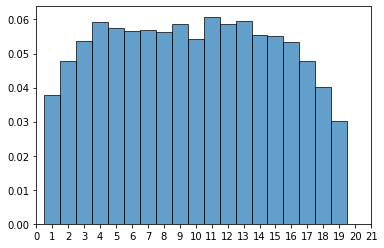

In [266]:
# Pobranie wyników
fit_df = fit.draws_pd()
positions = fit.stan_variable('position')
plt.hist(positions.flatten(), bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
plt.xticks(range(22))
plt.xlim([0, 21])
plt.show()

# Wyświetlenie wyników
# print(fit.summary())
# print("Positions:\n", positions)

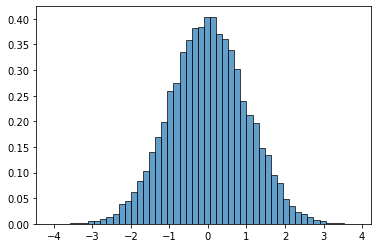

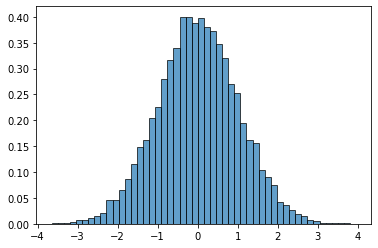

1.0


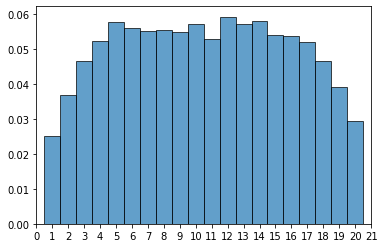

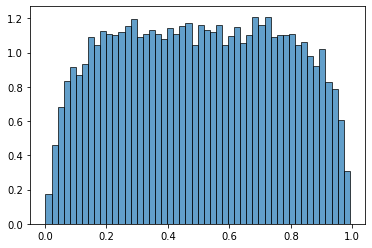

In [267]:
prior_y_rep = fit.stan_variable('driver_skill').flatten()
plt.hist(prior_y_rep, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.show()

prior_y_rep = fit.stan_variable('constructor_skill').flatten()
plt.hist(prior_y_rep, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.show()

prior_y_rep = fit.stan_variable('position').flatten() + 1
print(prior_y_rep.min())
plt.hist(prior_y_rep, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
plt.xticks(range(22))
plt.xlim([0, 21])
plt.show()

prior_y_rep = fit.stan_variable('theta').flatten()
plt.hist(prior_y_rep, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.show()



In [250]:
%%writefile stan/model1_posterior.stan
data {
    int<lower=1> N; // liczba obserwacji
    int<lower=1> D; // Liczba unikalnych kierowców
    int<lower=1> C; // Liczba unikalnych konstruktorow
    array [N] int<lower=1, upper=D> drivers; // indeksy kierowcow
    array [N] int<lower=1, upper=C> constructors; // indeksy konstruktorow
    array [N] int<lower=0, upper=19> position;
}

parameters {
    array[D] real driver_skill;
    array[C] real constructor_skill;
}

transformed parameters {
    array[N] real theta;
    for (i in 1:N) {
        theta[i] = inv_logit(driver_skill[drivers[i]] + constructor_skill[constructors[i]]);
    }
}

model {
    for (i in 1:D){
        driver_skill[i] ~ normal(2, 1);
    }
    for (i in 1:C){
        constructor_skill[i] ~ normal(2, 1);
    }
    position ~ binomial(19 , theta);
}

generated quantities {
    array [N] int position_predicted;

    for (i in 1:N) {
        position_predicted[i] = binomial_rng(19, theta[i]);
    }
}

Overwriting stan/model1_posterior.stan


In [2]:
# %%writefile stan/model1_posterior.stan
# data {
#     int N; // Number of observations
#     int D; // Number of unique drivers
#     int C; // Number of constructors
#     array [N] int<lower=1, upper=D> drivers;
#     array [N] int<lower=1, upper=C> constructors;
#     array [N] int<lower=0, upper=19> position;

#     real Wd; // Weight of Wins/Podiums finishes
#     array [D] real Pd; // Average points per race
#     real Qd; // Weight of qualifying performance
#     array [D] real Ad; // Average qualifying position
#     real Cd; // Weight of consistency
#     array [D] real Sd; // Standard deviation of race finishes
#     real sigma;
#     real Pc; // Weight of performance (Race Wins, Podiums)
#     real Rc; // Weight of reliability (finish rates)
# }

# parameters {
#     array [D] real Rd; // Driver skill rating
#     array [C] real Ccd; // Constructor skill rating
# }

# transformed parameters {
#     array [D] real Rd_transformed;
#     array [C] real Ccd_transformed;
#     array [N] real theta;

#     for (d in 1:D) {
#         Rd_transformed[d] = (Wd * Pd[d] / 200 + Qd * (2 - Ad[d] / 20) + Cd * (2 - Sd[d] / 5)) / 3;
#     }

#     for (c in 1:C) {
#         Ccd_transformed[c] = (Pc * 0 + Rc * 0) / 2; // Placeholder, actual computation in model block
#     }

#     for (i in 1:N) {
#         theta[i] = inv_logit(Rd[drivers[i]] + Ccd[constructors[i]]);
#     }
# }

# model {
#     // Priors
#     Rd ~ normal(0, sigma);
#     Ccd ~ normal(0, sigma);

#     // Likelihood
#     position ~ binomial(19, theta);
# }

# generated quantities {
#     vector[N] log_lik;
#     vector[N] y_hat;

#     array [D] real Rd_generated;
#     array [C] real Ccd_generated;

#     for (d in 1:D) {
#         Rd_generated[d] = (Wd * Pd[d] / 200 + Qd * (2 - Ad[d] / 20) + Cd * (2 - Sd[d] / 5)) / 3;
#     }

#     for (c in 1:C) {
#         Ccd_generated[c] = (Pc * normal_rng(0, sigma) * 2 + Rc * normal_rng(0, sigma) * 2) / 2;
#     }

#     for (j in 1:N) {
#         log_lik[j] = binomial_lpmf(position[j] | 19, theta[j]);
#         y_hat[j] = binomial_rng(19, inv_logit(Rd_generated[drivers[j]] + Ccd_generated[constructors[j]]));
#     }
# }


Overwriting stan/model1_posterior.stan


In [251]:
df = pd.read_csv('data_processing/processed_data.csv')
# Unikalne wartości kierowców i konstruktorów
unique_drivers = df['Name'].nunique()
unique_constructors = df['Constructor'].nunique()
print(unique_drivers)
print(unique_constructors)
# Indeksowanie kierowców i konstruktorów
drivers_indices = pd.factorize(df['Name'])[0] + 1
constructors_indices = pd.factorize(df['Constructor'])[0] + 1
#print(drivers_indices)
#print(constructors_indices)


df['Pos (race)'] = df['Pos (race)'] - 1
# Dane do modelu
positions = df['Pos (race)'].values

data_dict = {
    'N': len(df),
    'D': unique_drivers,
    'C': unique_constructors,
    'drivers': drivers_indices,
    'constructors': constructors_indices,
    'position': positions,

}

18
14


In [252]:
# Kompilacja modelu
model = CmdStanModel(stan_file='stan/model1_posterior.stan')

fit_posterior = model.sample(data=data_dict, iter_warmup=1, iter_sampling=1000, chains=1, seed=20052024)

INFO:cmdstanpy:compiling stan file /home/bayesian_f1/stan/model1_posterior.stan to exe file /home/bayesian_f1/stan/model1_posterior
INFO:cmdstanpy:compiled model executable: /home/bayesian_f1/stan/model1_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [253]:
df_posterior = fit_posterior.draws_pd()
df_posterior.head(5)
# print(f"min: {fit_posterior.stan_variable('y_hat').min()}")
# print(f"max: {fit_posterior.stan_variable('y_hat').max()}")
y_hat_stan = fit_posterior.stan_variable('position_predicted')
print(y_hat_stan.min())
y_hat_stan.max()

0.0


19.0

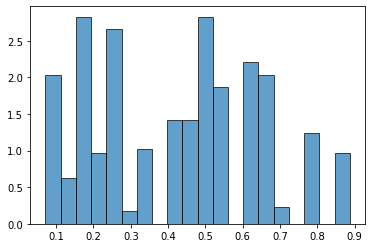

In [263]:
prior_y_rep = fit_posterior.stan_variable('theta').flatten()
plt.hist(prior_y_rep, bins=20, edgecolor='black', alpha=0.7, density=True)
plt.show()

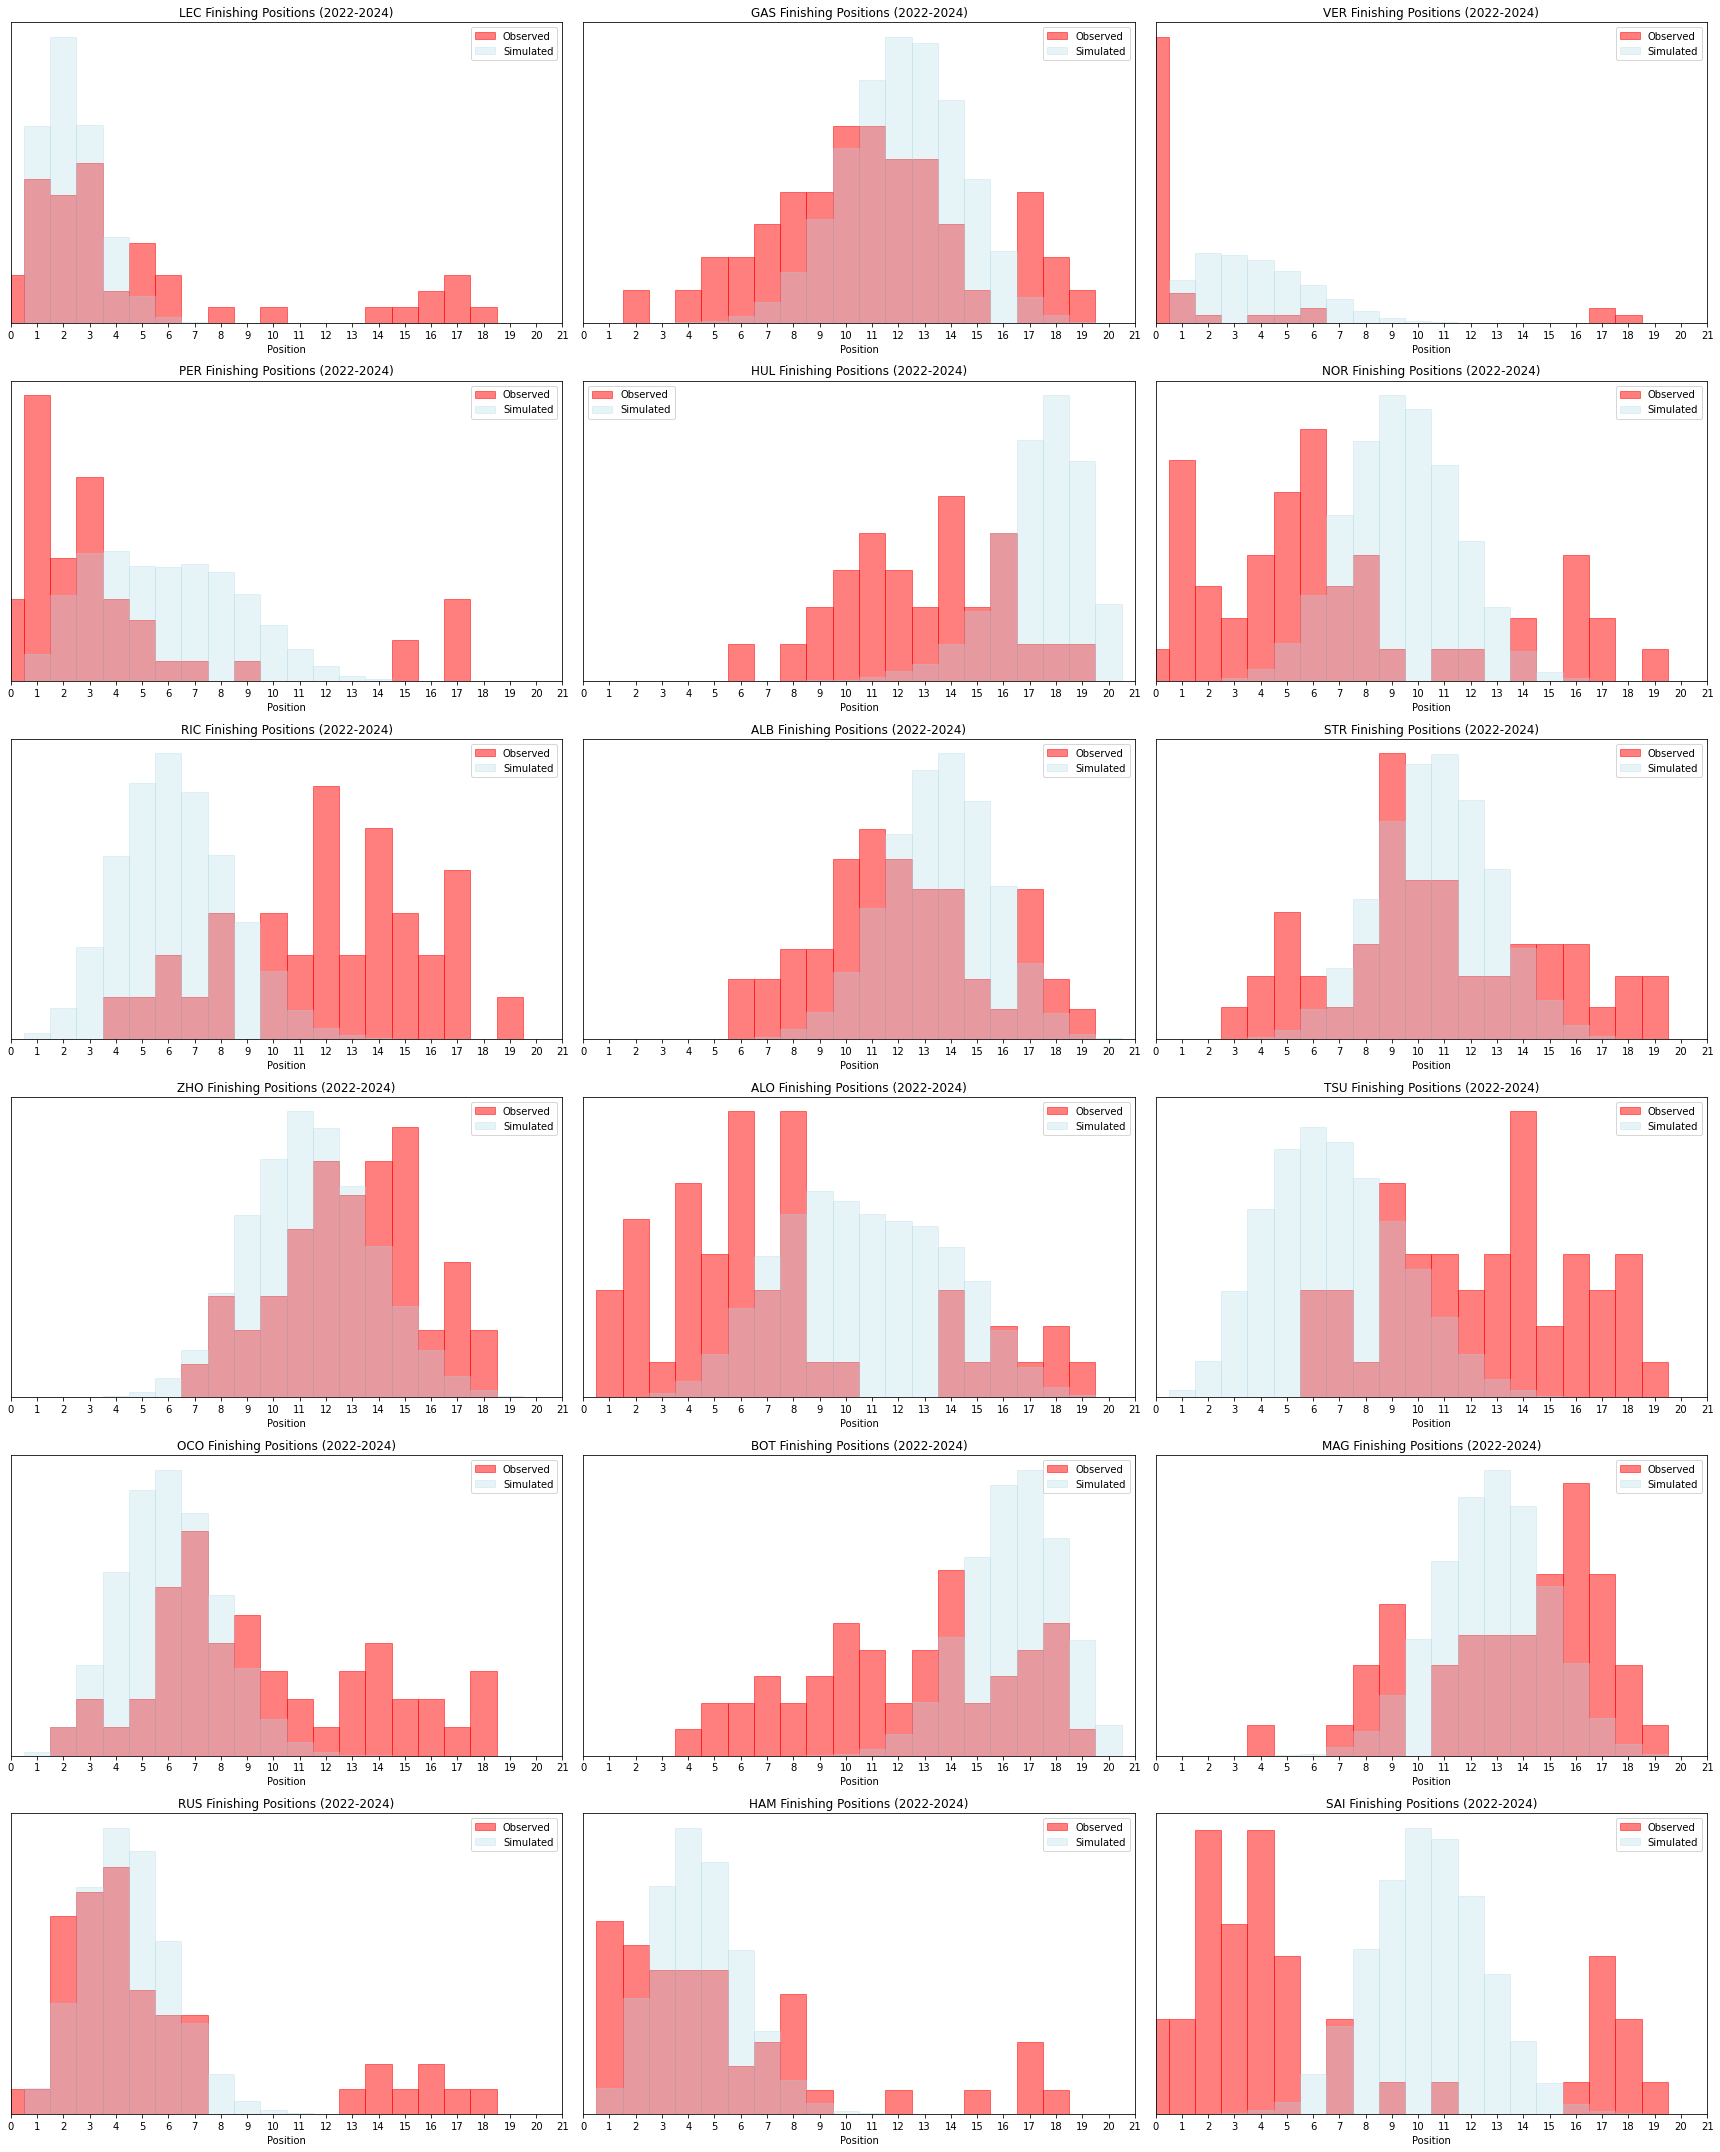

In [254]:
# Liczba wierszy i kolumn na wykresie
n_rows, n_cols = 6, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

# Zakres pozycji od 1 do 20
n_bins = np.arange(22) - 0.5

# Pobranie unikalnych nazw kierowców
drivers_names = df['Name'].unique().tolist()
#print(drivers_names)

# Iteracja po osiach wykresu
for d_i, d_name in enumerate(drivers_names):
    # Wybierz indeks kierowcy zgodnie z jego nazwą
    d_lookup_i = df['Name'].eq(d_name)
    # Wybierz dane dla danego kierowcy
    results = df[d_lookup_i]

    # Oblicz indeks wiersza i kolumny
    row_idx = d_i // n_cols
    col_idx = d_i % n_cols

    # Histogram dla prawdziwych pozycji
    axes[row_idx, col_idx].hist((results['Pos (race)']).tolist(), bins=n_bins, rwidth=1, color='red', edgecolor='red', density=True, label='Observed', alpha=0.5)

    # Pobierz indeksy wyników dla danego kierowcy
    results_idx = results.index
    # Pobierz przewidywane pozycje dla tych indeksów z y_hat
    simulated_positions = y_hat_stan.T[results_idx].flatten() + 1
    # Histogram dla przewidywanych pozycji
    axes[row_idx, col_idx].hist(simulated_positions, bins=n_bins, rwidth=1, color='lightblue', edgecolor='lightblue', density=True, label='Simulated', alpha=0.3)

    axes[row_idx, col_idx].set_xticks(range(22))
    axes[row_idx, col_idx].set_xlim([0, 21])
    axes[row_idx, col_idx].set_yticks([])
    axes[row_idx, col_idx].set_title(d_name.split()[-1] + ' Finishing Positions (2022-2024)')
    axes[row_idx, col_idx].legend()
    axes[row_idx, col_idx].set_xlabel('Position')

fig.tight_layout()
plt.show()

In [291]:
%%writefile stan/model2.stan
data {
    int<lower=1> D; // Liczba unikalnych kierowców
    array [D] int<lower=0, upper=1> rainy;
}

generated quantities {
    array[D] real driver_skill;
    array[D] real driver_skill_wet;
    array[D] real driver_skill_sum;
    array[D] real constructor_skill;
    array[D] real theta;
    array[D] int position;

    for (i in 1:D) {
        driver_skill[i] = normal_rng(0, 1);
        driver_skill_wet[i] = normal_rng(0, 2) * rainy[i];
        driver_skill_sum[i] = driver_skill[i] + driver_skill_wet[i];
        constructor_skill[i] = normal_rng(0, 1);
        theta[i] = inv_logit(driver_skill_sum[i] + constructor_skill[i]);
        position[i] = binomial_rng(19, theta[i]);
    }
}

Overwriting stan/model2.stan


In [292]:
df = pd.read_csv('data_processing/processed_data.csv')
unique_drivers = df['Name'].nunique() # unique drivers
D = 20
rainy = [0 if i % 2 == 0 else 1 for i in range(0, unique_drivers)]

data = {
    'D': unique_drivers,
    'rainy': rainy
}

# Kompilacja modelu
model = CmdStanModel(stan_file='stan/model2.stan')

# Uruchomienie próbkowania
fit = model.sample(data=data, iter_sampling=1000, chains=1, fixed_param=True)

INFO:cmdstanpy:compiling stan file /home/bayesian_f1/stan/model2.stan to exe file /home/bayesian_f1/stan/model2
INFO:cmdstanpy:compiled model executable: /home/bayesian_f1/stan/model2
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


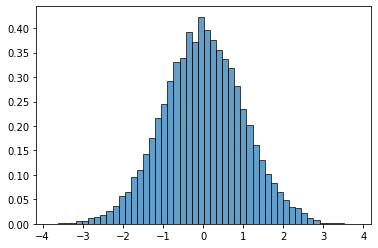

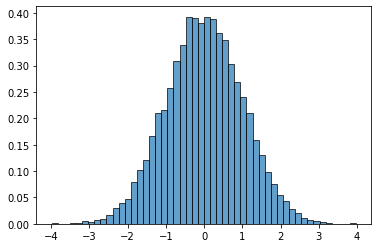

1.0


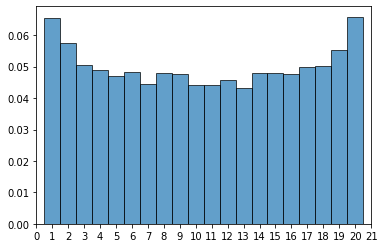

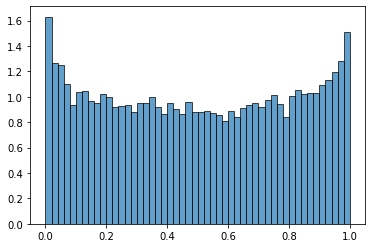

In [293]:
prior_y_rep = fit.stan_variable('driver_skill').flatten()
plt.hist(prior_y_rep, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.show()

prior_y_rep = fit.stan_variable('constructor_skill').flatten()
plt.hist(prior_y_rep, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.show()

prior_y_rep = fit.stan_variable('position').flatten() + 1
print(prior_y_rep.min())
plt.hist(prior_y_rep, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
plt.xticks(range(22))
plt.xlim([0, 21])
plt.show()

prior_y_rep = fit.stan_variable('theta').flatten()
plt.hist(prior_y_rep, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.show()


In [346]:
%%writefile stan/model2_posterior.stan
data {
    int<lower=1> N; // liczba obserwacji
    int<lower=1> D; // Liczba unikalnych kierowców
    int<lower=1> C; // Liczba unikalnych konstruktorow
    array [N] int<lower=1, upper=D> drivers; // indeksy kierowcow
    array [N] int<lower=1, upper=C> constructors; // indeksy konstruktorow
    array [N] int<lower=0, upper=19> position;
    array [N] int<lower=0, upper=1> rainy;
}

parameters {
    array[D] real driver_skill;
    array[C] real constructor_skill;
    array[D] real driver_skill_wet;
    //array[D] real driver_skill_sum;
}

transformed parameters {
    array[N] real theta;
    for (i in 1:N) {
        theta[i] = inv_logit(driver_skill[drivers[i]] + (driver_skill_wet[drivers[i]]*rainy[i]) + constructor_skill[constructors[i]]);
    }
}

model {
    for (i in 1:D){
        driver_skill[i] ~ normal(0, 1);
        driver_skill_wet[i] ~ normal(0, 2);
    }
    for (i in 1:C){
        constructor_skill[i] ~ normal(0, 1);
    }
    position ~ binomial(19 , theta);
}

generated quantities {
    array [N] int position_predicted;

    for (i in 1:N) {
        position_predicted[i] = binomial_rng(19, theta[i]);
    }
}

Overwriting stan/model2_posterior.stan


In [347]:
df = pd.read_csv('data_processing/processed_data.csv')
# Unikalne wartości kierowców i konstruktorów
#print(df['Pos (race)'].unique())
unique_drivers = df['Name'].nunique()
unique_constructors = df['Constructor'].nunique()
print(unique_drivers)
print(unique_constructors)
# Indeksowanie kierowców i konstruktorów
drivers_indices = pd.factorize(df['Name'])[0] + 1
constructors_indices = pd.factorize(df['Constructor'])[0] + 1
#print(drivers_indices)
#print(constructors_indices)


df['Pos (race)'] = df['Pos (race)'] - 1
#print(df['Pos (race)'].unique())
# Dane do modelu
positions = df['Pos (race)'].values

rainy = df['TotalRainfall'].astype(bool).values.astype(int)

data_dict = {
    'N': len(df),
    'D': unique_drivers,
    'C': unique_constructors,
    'drivers': drivers_indices,
    'constructors': constructors_indices,
    'position': positions,
    'rainy': rainy

}


18
14


In [348]:
# Kompilacja modelu
model = CmdStanModel(stan_file='stan/model2_posterior.stan')

fit_posterior = model.sample(data=data_dict, iter_warmup=1, iter_sampling=1000, chains=1, seed=20052024)

INFO:cmdstanpy:compiling stan file /home/bayesian_f1/stan/model2_posterior.stan to exe file /home/bayesian_f1/stan/model2_posterior
INFO:cmdstanpy:compiled model executable: /home/bayesian_f1/stan/model2_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [349]:
df_posterior = fit_posterior.draws_pd()
df_posterior.head(5)
# print(f"min: {fit_posterior.stan_variable('y_hat').min()}")
# print(f"max: {fit_posterior.stan_variable('y_hat').max()}")
y_hat_stan = fit_posterior.stan_variable('position_predicted')
print(y_hat_stan.min())
y_hat_stan.max()

0.0


19.0

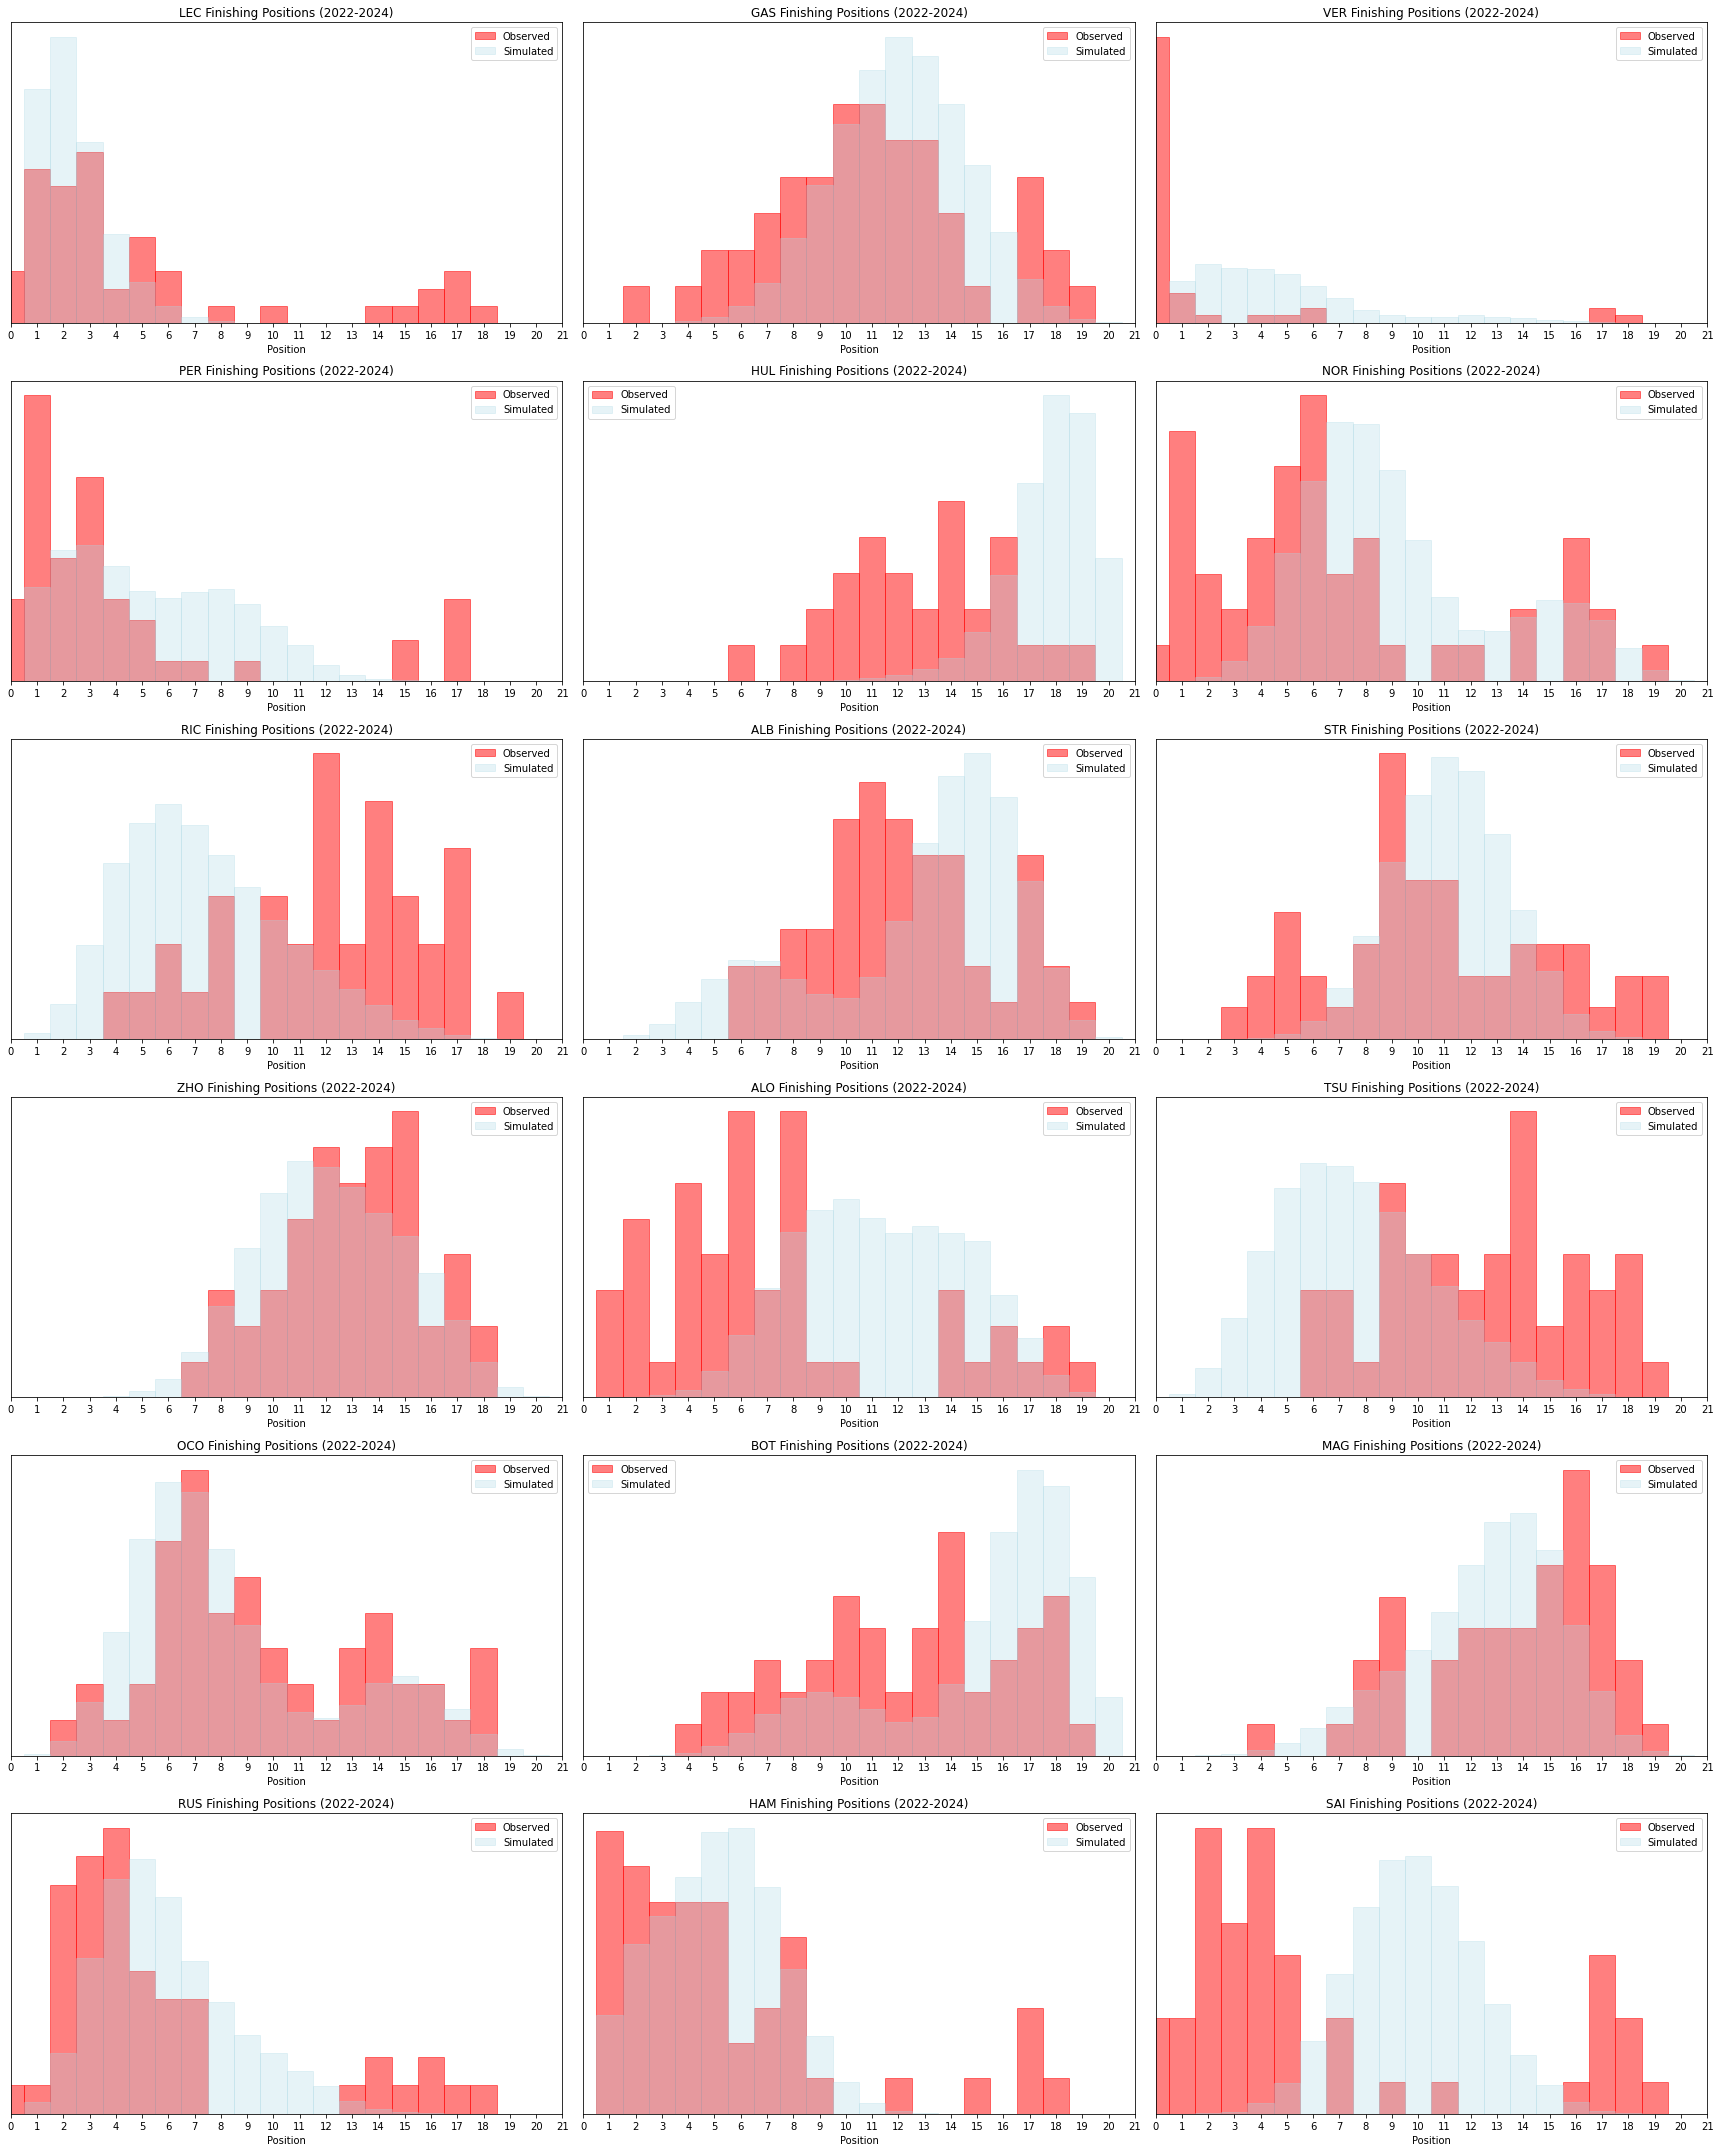

In [350]:
# Liczba wierszy i kolumn na wykresie
n_rows, n_cols = 6, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

# Zakres pozycji od 1 do 20
n_bins = np.arange(22) - 0.5

# Pobranie unikalnych nazw kierowców
drivers_names = df['Name'].unique().tolist()
#print(drivers_names)

# Iteracja po osiach wykresu
for d_i, d_name in enumerate(drivers_names):
    # Wybierz indeks kierowcy zgodnie z jego nazwą
    d_lookup_i = df['Name'].eq(d_name)
    # Wybierz dane dla danego kierowcy
    results = df[d_lookup_i]

    # Oblicz indeks wiersza i kolumny
    row_idx = d_i // n_cols
    col_idx = d_i % n_cols

    # Histogram dla prawdziwych pozycji
    axes[row_idx, col_idx].hist((results['Pos (race)']).tolist(), bins=n_bins, rwidth=1, color='red', edgecolor='red', density=True, label='Observed', alpha=0.5)

    # Pobierz indeksy wyników dla danego kierowcy
    results_idx = results.index
    # Pobierz przewidywane pozycje dla tych indeksów z y_hat
    simulated_positions = y_hat_stan.T[results_idx].flatten() + 1
    # Histogram dla przewidywanych pozycji
    axes[row_idx, col_idx].hist(simulated_positions, bins=n_bins, rwidth=1, color='lightblue', edgecolor='lightblue', density=True, label='Simulated', alpha=0.3)

    axes[row_idx, col_idx].set_xticks(range(22))
    axes[row_idx, col_idx].set_xlim([0, 21])
    axes[row_idx, col_idx].set_yticks([])
    axes[row_idx, col_idx].set_title(d_name.split()[-1] + ' Finishing Positions (2022-2024)')
    axes[row_idx, col_idx].legend()
    axes[row_idx, col_idx].set_xlabel('Position')

fig.tight_layout()
plt.show()